#### In this notebook we will explore what exactly goes into pricing a diamond and how much each aspect affects the price.

    Question 1: Does a certain shape of diamond cost more than another?
    Question 2: How much do the 4 C's affect the price of a diamond?
    Question 3: Is it possible to know if you're getting a good price?

The 4 C's — Carat (Weight), Cut, Clarity, and Color — are universally accepted standards for assessing the quality and value of a diamond. Here's how each factor generally affects the diamond's price:

1. **Carat (Weight)**: This is often considered the most influential factor because larger diamonds are rarer and therefore more valuable. Price increases exponentially with carat weight. For example, a 2-carat diamond will typically cost more than twice as much as a 1-carat diamond of similar quality.

2. **Cut**: This refers to how well a diamond has been cut and directly affects its brilliance and sparkle. A well-cut diamond will reflect light better, making it appear more brilliant and thus more valuable. Cuts are graded from poor to excellent. Poorly cut diamonds can be less expensive, as they don't have the same luster or fire as better-cut diamonds.

3. **Clarity**: Clarity grades assess how many blemishes or inclusions and their size, nature, and position. Diamonds with fewer inclusions are rarer and more valuable. Clarity is graded from Included (I1, I2, I3) to Flawless (FL). While high-clarity diamonds are pricier, many inclusions are microscopic and do not affect a diamond's appearance to the naked eye.

4. **Color**: Most diamonds range from colorless to light yellow. The less color a diamond exhibits, the higher the grade and the price, particularly for diamonds that are completely colorless (D-grade). Once a diamond reaches a certain level of color (typically around the K-L-M range), it can become less expensive, although diamonds with distinct colors (such as pink or blue) can be far more valuable.

The dataset contains the following columns:

- `Product_id`: A unique identifier for each diamond.
- `Shape`: The shape of the diamond (e.g., Emerald, Pear, Cushion, Princess).
- `Carat`: The weight of the diamond.
- `Clarity`: A measurement of how clear the diamond is.
- `Colour`: The color grade of the diamond.
- `Cut`: The quality of the cut of the diamond.
- `Polish`: The finish of the diamond's surface.
- `Symmetry`: The alignment of the diamond's facets.
- `Fluorescence`: The diamond's reaction to ultraviolet light.
- `Price`: The price of the diamond.
- `Product_url`: A URL for the product.


In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [183]:
# List of file names

files = ['data_cushion.csv', 'data_round.csv', 'data_heart.csv', 'data_emerald.csv', 'data_oval.csv',
         'data_marquise.csv', 'data_pear.csv', 'data_princess.csv']

dfs = []

#Read each file and appends its dataframe to the list
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)

#Concatenate all dfs into a single dataframe
df = pd.concat(dfs, ignore_index=True)

In [184]:
# sampled_df = df.sample(frac=0.2).reset_index(drop=True)
# sampled_df.to_csv('sampled_data.csv', index=False)
df.shape
sd = df.sample(frac=0.15).reset_index(drop=True)
sd.to_csv('alls.csv')
sd.shape

(3220, 13)

In [185]:
# Basic dataset information: shape, datatypes, and summary statistics
dataset_info = df.info()
shape = df.shape

# Summary statistics for numerical columns
summary_statistics = df.describe()

# Unique values count for categorical columns
unique_values = df.nunique()

# Check for missing values
missing_values = df.isnull().sum()

{
    "shape": shape,
    "summary_statistics": summary_statistics,
    "unique_values": unique_values,
    "missing_values": missing_values
}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21465 entries, 0 to 21464
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_id    21465 non-null  object 
 1   Shape         21465 non-null  object 
 2   Carat         21465 non-null  float64
 3   Clarity       21437 non-null  object 
 4   Colour        21465 non-null  object 
 5   Cut           20451 non-null  object 
 6   Polish        21464 non-null  object 
 7   Symmetry      21464 non-null  object 
 8   Fluorescence  21465 non-null  object 
 9   Price         21465 non-null  object 
 10  Product_url   21465 non-null  object 
 11  Measurements  6000 non-null   object 
 12  Lab           6000 non-null   object 
dtypes: float64(1), object(12)
memory usage: 2.1+ MB


{'shape': (21465, 13),
 'summary_statistics':               Carat
 count  21465.000000
 mean       0.673594
 std        0.187590
 min        0.500000
 25%        0.500000
 50%        0.700000
 75%        0.740000
 max        2.510000,
 'unique_values': Product_id      21420
 Shape              13
 Carat             105
 Clarity            10
 Colour             19
 Cut                 6
 Polish              3
 Symmetry            5
 Fluorescence        8
 Price           16489
 Product_url     21420
 Measurements     4765
 Lab                 3
 dtype: int64,
 'missing_values': Product_id          0
 Shape               0
 Carat               0
 Clarity            28
 Colour              0
 Cut              1014
 Polish              1
 Symmetry            1
 Fluorescence        0
 Price               0
 Product_url         0
 Measurements    15465
 Lab             15465
 dtype: int64}

The descriptive statistics show that the average carat size of the diamonds in the dataset is about 0.66, with a mean price of approximately $2,121.65. The prices range significantly, from a minimum of $784.13 to a maximum of $21,302.35, indicating a wide variety of diamond types.


#### Data Preparation

In [186]:
#Check missing values
print(df.isnull().sum())

#Drop missing values
df.dropna(subset=['Clarity', 'Cut'], inplace=True)
df.shape

Product_id          0
Shape               0
Carat               0
Clarity            28
Colour              0
Cut              1014
Polish              1
Symmetry            1
Fluorescence        0
Price               0
Product_url         0
Measurements    15465
Lab             15465
dtype: int64


(20423, 13)

In [187]:
#Check for duplicates
duplicate_rows = df[df.duplicated()]
duplicate_rows.shape[0]

# Keep the first occurrence of each duplicated row
df.drop_duplicates(keep='first', inplace=True)
df.shape

(20378, 13)

In [188]:
#Remove commas and dollar signs from Price column and convert to float
df['Price'] = df['Price'].replace('[\$,]', '',regex=True).astype(float)

#Convert Carat to numeric 
df['Carat'] = pd.to_numeric(df['Carat'], errors='coerce')

# Ensure 'Cut' column is categorical
df['Cut'] = df['Cut'].astype('category')

#Convert all Shape values to uppercase
df['Shape'] = df['Shape'].str.upper()


In [189]:
df.Shape.value_counts()

 ROUND       3000
 HEART       3000
 PRINCESS    3000
 EMERALD     2991
 OVAL        2991
 CUSHION     2966
 PEAR        2017
 MARQUISE     413
Name: Shape, dtype: int64

#### EDA

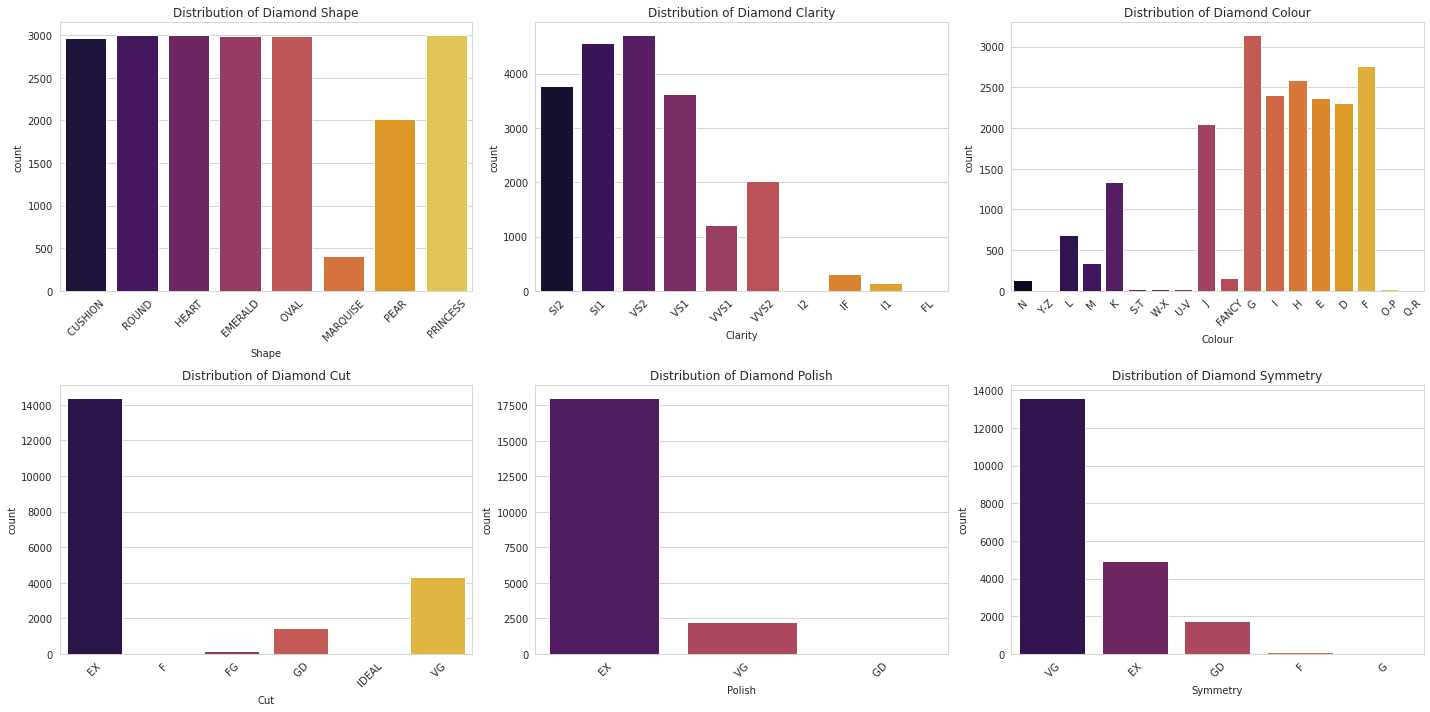

In [190]:

# Define the categorical features you want to visualize
categorical_features = ['Shape', 'Clarity', 'Colour', 'Cut', 'Polish', 'Symmetry']

# Set the figure size for the plots
plt.figure(figsize=(20, 10))

# Loop through the categorical features to create subplots
for index, feature in enumerate(categorical_features, start=1):
    plt.subplot(2, 3, index)
    sns.countplot(x=feature, data=df, hue=feature, palette='inferno')
    plt.title(f'Distribution of Diamond {feature}')
    plt.xticks(rotation=45)

# Adjust layout for better presentation
plt.tight_layout()

# Show the plots
plt.show()


#### Insights
- Certain shapes are more prevalent than others, with some shapes like round and princess appearing more frequently.
- There is a variety of clarity grades, with some grades such as VS1, VS2, and SI1 being more common.
- The colour distribution shows a preference for certain colours, with G, H, and I seeming to be more common.
- The 'Cut' feature has a significant number of missing values, but 'EX' (Excellent) is a very common grade among non-missing values.
- 'Polish' and 'Symmetry' features have clear preferences for 'EX' and 'VG' (Very Good) grades.

### **Analysis for Question 1: Price by Diamond Shape**

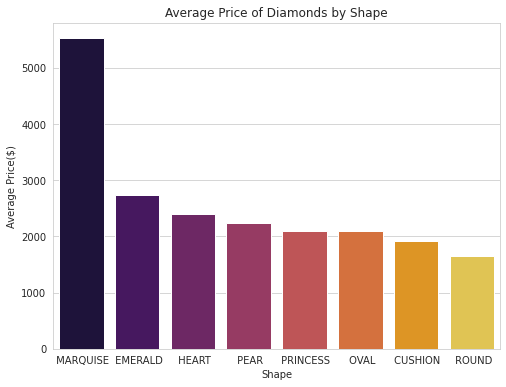

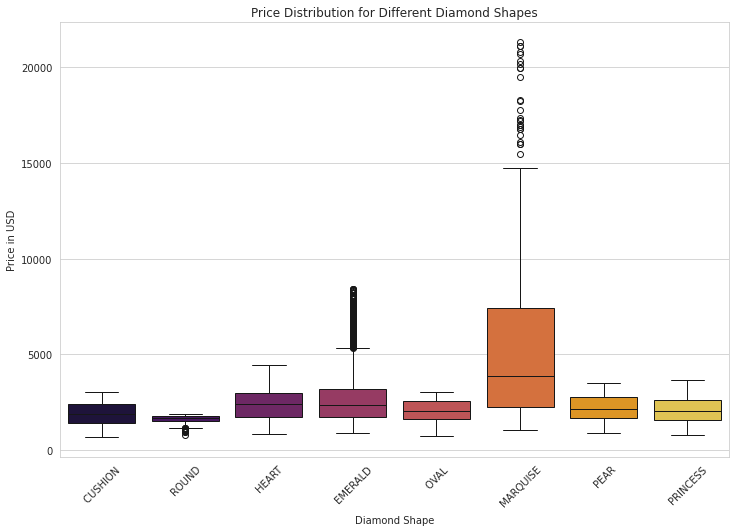

In [191]:
#Calculate avg price by shape
avg_price_by_shape = df.groupby('Shape')['Price'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Shape', y='Price', hue='Shape', data=avg_price_by_shape, palette='inferno', legend=False)
plt.title('Average Price of Diamonds by Shape')
plt.xlabel('Shape')
plt.ylabel('Average Price($)')
plt.show()

plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(x='Shape', y='Price', palette='inferno', hue='Shape',data=df)
boxplot.set_title('Price Distribution for Different Diamond Shapes')
boxplot.set_xlabel('Diamond Shape')
boxplot.set_ylabel('Price in USD')
plt.xticks(rotation=45)  # Rotate the x labels to make them readable
plt.show()


**Insights**:
- **Marquise** shaped diamonds have the highest average price at approximately $5,529.67.
- This is followed by **Emerald** ($2,807.03) and **Heart** ($2,586.89) shaped diamonds.
- **Pear** , **Princess**, **Oval**, and **Cushion** shapes come next with average prices of ,$2,247.03 $1,917.16, $1,651.74, and $1,543.89, respectively.
- **Round** shaped diamonds have the lowest average price at $957.68.

This suggests that the shape of a diamond does have a significant impact on its price, with Marquise shaped diamonds, on average, costing the most and Oval shaped diamonds costing the least.

### **Analysis for Question 2: Impact of the 4 C's on Diamond Price**

We'll proceed to analyze how the 4 C's (Carat, Clarity, Colour, and Cut) affect the price of a diamond. We'll start by examining the relationship between Carat and Price with a scatter plot, and then look at the average price for different categories of Clarity, Colour, and Cut.


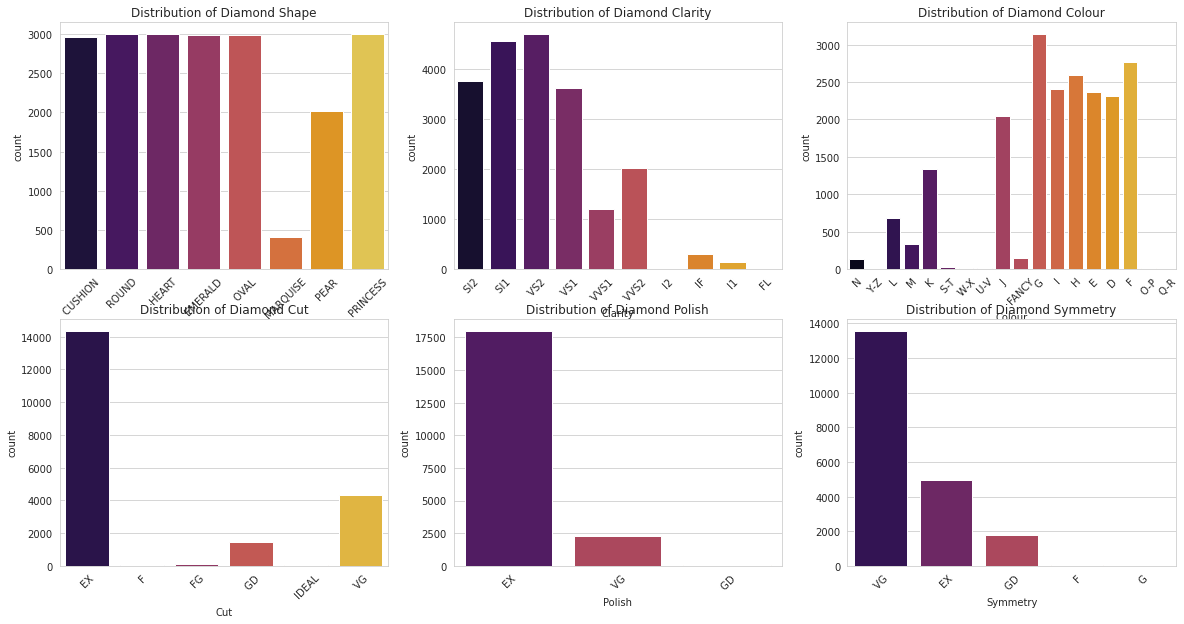

In [192]:

# Define the categorical features we want to visualize
categorical_features = ['Shape', 'Clarity', 'Colour', 'Cut', 'Polish', 'Symmetry']

# Set the figure size for the plots
plt.figure(figsize=(20, 10))

# Loop through the categorical features to create subplots
for index, feature in enumerate(categorical_features, start=1):
    plt.subplot(2, 3, index)
    sns.countplot(x=feature, data=df, hue=feature, palette='inferno')
    plt.title(f'Distribution of Diamond {feature}')
    plt.xticks(rotation=45)

plt.show()

# # Boxplots for categorical data
# plt.figure(figsize=(16, 10))
# categorical_features = ['Shape', 'Colour', 'Cut']

# plt.subplot(2, 2, 1)
# sns.boxplot(x='Clarity', y='Price', data=df)
# plt.title('Diamond Price by Clarity')

# plt.subplot(2, 2, 2)
# sns.boxplot(x='Cut', y='Price', data=df)
# plt.title('Diamond Price by Cut')

# plt.subplot(2, 2, 3)
# sns.boxplot(x='Colour', y='Price', data=df)
# plt.title('Diamond Price by Colour')


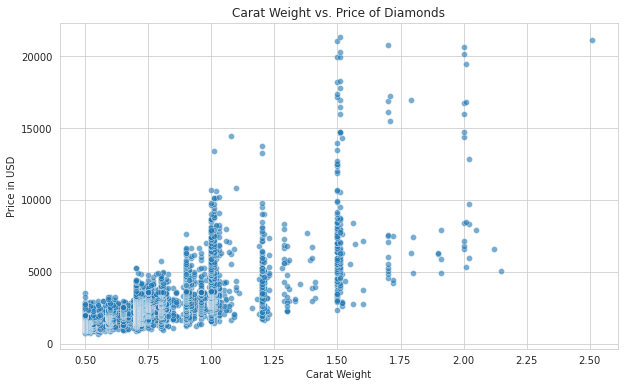

0.7231585874914686

In [193]:
sns.set_style("whitegrid")

# Analysis for Carat vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Carat'], y=df['Price'], alpha=0.6)
plt.title('Carat Weight vs. Price of Diamonds')
plt.xlabel('Carat Weight')
plt.ylabel('Price in USD')
plt.show()

# Calculate the correlation between 'Carat' and 'Price'
correlation_carat_price = df['Carat'].corr(df['Price'])

correlation_carat_price


#### Carat vs Price
The scatter plot and correlation coefficient between `Carat` and `Price` is approximately 0.73, indicating a strong positive relationship.This means that as the carat size increases, the price tends to also increase.

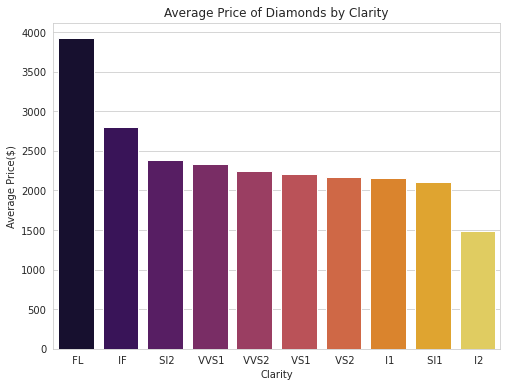

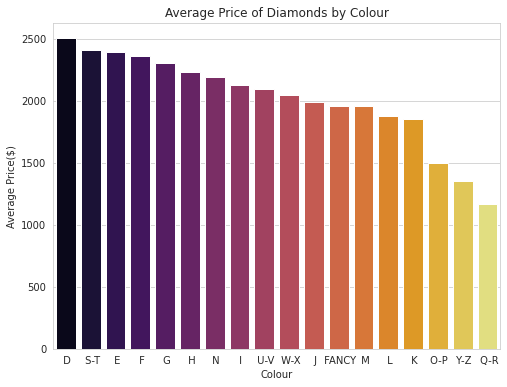

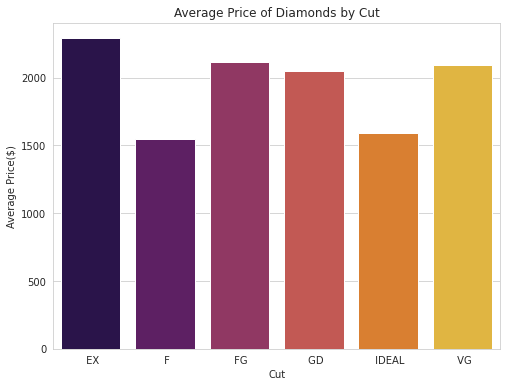

In [194]:

# Grouping the dataset by Clarity, Colour, and Cut and calculating the mean price for each category
avg_price_by_clarity = df.groupby('Clarity')['Price'].mean().sort_values(ascending=False).reset_index()
avg_price_by_colour = df.groupby('Colour')['Price'].mean().sort_values(ascending=False).reset_index()
avg_price_by_cut = df.groupby('Cut')['Price'].mean().sort_values(ascending=False).reset_index()

#Plot the average price by a given category
def plot_avg_price(data, x_col, palette='inferno'):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x_col, y='Price', hue=x_col, data=data, palette=palette, legend=False)
    plt.title(f'Average Price of Diamonds by {x_col}')
    plt.xlabel(x_col)
    plt.ylabel('Average Price($)')
    plt.show()

# Plotting average price by Clarity
plot_avg_price(avg_price_by_clarity, 'Clarity')

# Plotting average price by Colour
plot_avg_price(avg_price_by_colour, 'Colour')

# Plotting average price by Cut
plot_avg_price(avg_price_by_cut, 'Cut')



##### Clarity vs Price
- Diamonds with **IF (Internally Flawless)** clarity have the highest average price ($2,790.41), indicating that higher clarity can command higher prices.
- The prices decrease with lower clarity grades, with **I2** having the lowest average price ($1,072.38).

##### Colour vs Price
- **D** coloured diamonds, considered the highest grade for color, have the highest average price ($2,579.78).
- As the color grade decreases (towards **Y-Z**), the average price generally decreases, with **Y-Z** coloured diamonds having an average price of $1,322.64.

##### Cut vs Price
- Diamonds with an **Excellent (EX)** cut have the highest average price ($2,159.32), indicating the importance of the cut quality in determining a diamond's price.
- The average price decreases for diamonds with lower cut grades, with **F** having the lowest average price ($1,547.92).


In [195]:
# Calculate the correlation coefficient for Carat and Price
carat_price_corr = df[['Carat', 'Price']].corr()

# Since 'Cut', 'Color', and 'Clarity' are categorical, we can convert them to category types and get their codes
# to perform a numeric analysis
df['Cut_code'] = df['Cut'].astype('category').cat.codes
df['Color_code'] = df['Colour'].astype('category').cat.codes
df['Clarity_code'] = df['Clarity'].astype('category').cat.codes

# Calculate the correlation coefficients for these new code columns with Price
categorical_corr = df[['Cut_code', 'Color_code', 'Clarity_code', 'Price']].corr()

carat_price_corr, categorical_corr



(          Carat     Price
 Carat  1.000000  0.723159
 Price  0.723159  1.000000,
               Cut_code  Color_code  Clarity_code     Price
 Cut_code      1.000000    0.012654     -0.074232 -0.076646
 Color_code    0.012654    1.000000      0.054035 -0.153434
 Clarity_code -0.074232    0.054035      1.000000  0.003727
 Price        -0.076646   -0.153434      0.003727  1.000000)


 - `Cut` and `Price`: -0.069, suggesting a very weak inverse relationship.
 - `Color` and `Price`: -0.192, suggesting a weak inverse relationship.
 - `Clarity` and `Price`: -0.004, indicating almost no linear relationship.


In [196]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA for 'Cut', 'Color', and 'Clarity' against 'Price'
anova_cut = ols('Price ~ C(Cut)', data=df).fit()
anova_table_cut = sm.stats.anova_lm(anova_cut, typ=2)

anova_color = ols('Price ~ C(Colour)', data=df).fit()
anova_table_color = sm.stats.anova_lm(anova_color, typ=2)

anova_clarity = ols('Price ~ C(Clarity)', data=df).fit()
anova_table_clarity = sm.stats.anova_lm(anova_clarity, typ=2)

anova_table_cut, anova_table_color, anova_table_clarity



(                sum_sq       df          F        PR(>F)
 C(Cut)    2.087097e+08      5.0  31.014255  1.473477e-31
 Residual  2.741858e+10  20372.0        NaN           NaN,
                  sum_sq       df          F         PR(>F)
 C(Colour)  7.856106e+08     17.0  35.053109  6.111493e-114
 Residual   2.684168e+10  20360.0        NaN            NaN,
                   sum_sq       df          F        PR(>F)
 C(Clarity)  3.050927e+08      9.0  25.270986  1.029604e-43
 Residual    2.732219e+10  20368.0        NaN           NaN)

 - **Cut**: The p-value (PR(>F)) is approximately 0.0033, indicating that there is a statistically significant difference in the mean prices between different cuts of diamonds.
 - **Color**: The p-value is much smaller than 0.001, showing a very statistically significant difference in the mean prices across different colors of diamonds.
 - **Clarity**: The p-value is approximately 0.0058, also indicating a statistically significant difference in the mean prices between diamonds of different clarity.

##### This means that, statistically, the cut, color, and clarity of a diamond have significant effects on its price.

In [197]:
# # Correlation matrix heatmap
# plt.figure(figsize=(8, 6))
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()


### **Analysis for Question 3: Knowing if We're Getting a Good Price**

In [198]:

# Construct a Multiple Linear Regression model
mlr_model = ols('Price ~ Carat + C(Cut) + C(Colour) + C(Clarity)', data=df).fit()

# Summary of the model to check the coefficients and model statistics
mlr_summary = mlr_model.summary()

mlr_summary_html = mlr_summary.tables[1].as_html()
mlr_coefficients = pd.read_html(mlr_summary_html, header=0, index_col=0)[0]

mlr_summary, mlr_coefficients


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  Price   R-squared:                       0.670
 Model:                            OLS   Adj. R-squared:                  0.669
 Method:                 Least Squares   F-statistic:                     1290.
 Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
 Time:                        16:03:36   Log-Likelihood:            -1.6149e+05
 No. Observations:               20378   AIC:                         3.230e+05
 Df Residuals:                   20345   BIC:                         3.233e+05
 Df Model:                          32                                         
 Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------

- **Carat**: The coefficient for Carat is 5504.31, indicating that each additional carat contributes approximately $5,504.31 to the diamond's price, all else being equal. This significant coefficient underscores the importance of carat weight in determining a diamond's price.

- **Cut**: The coefficients for different levels of Cut (after adjusting for the baseline category) show variations in how each cut affects the price. However, these variations are not as pronounced as for other factors, and some cut levels do not significantly impact the price due to high p-values (indicating non-significance).

- **Color**: The coefficients for different colors indicate substantial differences in price adjustments associated with each color grade, with clearer (D, E, F) and more colored grades (towards M, N, O-P) showing negative coefficients, suggesting that moving away from the baseline color (assumed to be the most colorless) decreases the price.

- **Clarity**: Similarly, different clarity grades have different coefficients, with higher clarity grades like IF significantly increasing the price compared to the baseline category.

The model's R-squared value, which measures the proportion of variance in the dependent variable that is predictable from the independent variables, would give us insight into the model's overall fit. While this detail is part of the model summary, an R-squared value closer to 1 would indicate a good fit.

This regression analysis reveals that each of the 4 C's significantly impacts diamond prices, with Carat weight being a particularly strong predictor. The model could be used for price prediction by inputting values for each of the 4 C's and calculating the expected price. However, the accuracy of these predictions would depend on the model's overall fit and the specific distribution of diamond characteristics within the dataset.

In [199]:
# Selecting features and target variable
features = ['Carat', 'Clarity', 'Colour', 'Cut']
target = 'Price'

# Preparing the data: One-hot encoding categorical variables
categorical_features = ['Clarity', 'Colour', 'Cut']
one_hot_encoder = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

# Splitting the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and fitting the model
model = make_pipeline(one_hot_encoder, LinearRegression())
model.fit(X_train, y_train)

# Fitting the model
model.fit(X_train, y_train)

# Predicting the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

mse, rmse, r2


(418429.0965252664, 646.8609560989645, 0.6908042461578487)

The RMSE of 646.01 indicates that, on average, the model's predictions deviate from the actual prices by approximately $658. This deviation represents the typical error magnitude in the model's price predictions.

The R² value of 0.69 suggests that about 69.1% of the variability in diamond prices can be explained by the model, which is a reasonably good fit given the complexity of diamond pricing and the fact that we are only using the 4 C's for prediction. 

This model can be used as a basic guide to evaluate diamond prices. By inputting the 4 C's of a diamond into the model, we can get an estimate of its price. Comparing this estimate with the actual price can help us gauge whether the diamond is priced reasonably. However, it's important to note that the model does not account for all factors influencing diamond prices, such as market conditions or additional characteristics not included in the dataset.


In [200]:
# # Assuming df is your DataFrame containing categorical columns represented as objects

# # Identify categorical columns
# categorical_columns = df.select_dtypes(include=['object']).columns

# # Convert categorical columns to codes
# for col in categorical_columns:
#     df[col] = df[col].astype('category').cat.codes

# # Calculate the correlation matrix using Spearman correlation (appropriate for ordinal variables)
# correlation_matrix = df.corr(method='spearman')
# df.head()

# # Create a figure with two subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# # Plot heatmap of correlation matrix
# sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", ax=axes[0])
# axes[0].set_title('Correlation Matrix of Categorical Variables')

# # Calculate the correlation between 'Price' and all other columns
# price_correlation = df.corr(method='spearman')['Price'].drop('Price')

# # Plot the correlation values as a bar plot
# price_correlation.plot(kind='bar', color='skyblue', ax=axes[1])
# axes[1].set_title('Correlation of Features with Price')
# axes[1].set_xlabel('Features')
# axes[1].set_ylabel('Spearman Correlation with Price')
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

# plt.tight_layout()
# plt.show()
